# Recolección de datos

In [1]:
import requests
import pandas as pd

In [4]:
def consultar(pais: str, indicador:str, pagina:int = 1):

    '''Función que contacta a la API y devuelve la respuesta
    que brinda la misma en formato json'''

    # Página de la api y path al recurso solicitado
    api_url = 'http://api.worldbank.org/v2/es'
    path = f'/country/{pais}/indicator/{indicador}'
    url = api_url + path

    # Creamos el diccionario con los parametros 
    # para el método get
    args= {
        "date":'1990:2020',
        'page':pagina,
        "per_page":1000,
        "format":"json",
        "prefix":"Getdata",
    }
   
    return requests.get(url,params=args).json()

In [5]:
def consultar_por_pais():
    '''Función que retorna un código de país,
    para, en caso que se quiera o se solicite,
    consultar en tiempo real la API'''
    paises=pd.read_parquet('../datasets/paises.parquet')

    seleccion = input("Ingrese un nombre de país: ")
    try:
        pais = paises.loc[paises.name.str.contains(seleccion, case=False),'id'].values[0]
    except:
        print("No se encontró el país, intente de nuevo")

In [217]:
# Estos indicadores fueron seleccionados 
# de forma manual al final del documento
indicadores = pd.read_csv('../datasets/indicadores_seleccionados.csv')

diccionario = { a:b for a,b in zip(indicadores.id.to_list(), 
          indicadores.name.to_list())}

In [6]:
def carga_incremental(pais, indicador):
    '''Función que a partir de un país y un indicador 
    llama a consultar y establece qué tipo de contenido tiene
    según eso devuelve o no un dataframe con todos los datos'''

    consulta = consultar(pais, indicador)
    try:
        # La primera parte de la respuesta nos indica en 
        # cuantas páginas de encuentra la información
        paginas = consulta[0]["pages"]

        # La segunda parte nos retorna una lista de 
        # diccionarios con la información que queríamos
        datos=consulta[1]

    except:
        print('No hay datos para:', indicador, pais)
        pass
    else:
        if paginas >= 1:
            # Agregamos los valores de las otras páginas a
            # nuestra lista de diccionarios
            for pagina in range(2,paginas+1):
                datos.extend(consultar(pais, indicador, pagina)[1])

            # Creo el DataFrame con todos los datos
            data = pd.json_normalize(datos)
            return data
        return pd.DataFrame(['error'],columns=['no_data'])


In [ ]:
for indicador in diccionario:
    print(indicador)
    datos = carga_incremental(pais='all', indicador=indicador)

    # Guardo el dataframe resultante
    datos.to_parquet(f'../data_lake/df_TWB_{indicador}.parquet')
    print('Guardado')


# ETL

## Búsqueda de indicadores

La lista de indicadores bajo estudio se selecciona de forma manual a partir de los datos que indican distintas tesis de estudio. De todas formas los indicadores pasarán por un tamiz de análisis exploratorio

In [19]:
indicadores_todos = pd.read_csv('../datasets/indicadores.csv')

# Se completó los valores faltantes con 'na'
# para poder buscar sobre el dataframe
indicadores_todos.fillna('na',inplace=True)

In [37]:
interes = input("Indicador de interés: ")
indicadores_todos.loc[
     indicadores_todos.name.str.contains(interes,case=False),
     ['id','name','sourceNote']
     ]#.to_csv('temp.csv')

,id,name,sourceNote
17810,SP.POP.TOTL.FE.IN,"Población, mujeres","Población, mujeres"
17811,SP.POP.TOTL.FE.ZS,"Población, mujeres (% del total)",La población femenina es el porcentaje de la p...


In [26]:
interes = input("Indicador de interés: ")
seleccion = indicadores_todos.loc[indicadores_todos.id == interes,
     ['id','name','sourceNote']]
seleccion

,id,name,sourceNote
17815,SP.POP.TOTL.MA.ZS,"Población, hombres (% del total)",na


In [6]:
indicador_selec = pd.DataFrame()

In [108]:
indicador_selec = pd.concat([indicador_selec, seleccion], 
                            ignore_index=True)

## Exploración de los Datasets obtenidos

In [2]:
naciones_unidas = {
    "df_UNPD_mort_22" : "tasa_mortalidad_infantil",
    "df_UNPD_pop_54": "densidad_población_por_kilómetro_cuadrado)",
    "df_UNPD_imigrt_65": "migración_neta_total",
    "df_UNPD_pop_49": "población_total_por_sexo",
    "df_UNPD_mort_60": "total_muertes_por_sexo",
    "df_UNPD_pop_53": "tasa_bruta_cambio_natural_población",
    "df_UNPD_imigrt_66": "tasa_bruta_migración_neta",
    "df_UNPD_pop_72": "proporción_sexos_población_total",
    "df_UNPD_fam_1": "prevalencia_anticonceptivos_porcentaje",
    "df_UNPD_pop_67": "mediana_edad_población",
    "df_UNPD_mort_59": "tasa_bruta_mortalidad_por_1000_habitantes",
    "df_UNPD_pop_51": "tasa_bruta_variación_total_población",
    "df_UNPD_pop_50": "cambio_de_la_población",
    "df_UNPD_pop_41": "población_femenina_edad_reproductiva_(15-49 años)",
    "df_UNPD_mort_24": "tasa_mortalidad_menores_cinco_años",
    "df_UNPD_pop_52": "cambio_natural_población",
    "df_UNPD_fert_19": "tasa_fertilidad",
    "df_UNPD_marstat_42": "estado_civil_casado_porcentaje",
}

In [3]:
organizacion_salud = {'df_OMS_NUTRITION_ANAEMIA_CHILDREN_PREV': 'tasa_anemia_niños(%)',
'df_OMS_NUTRITION_ANAEMIA_REPRODUCTIVEAGE_PREV': 'tasa_anemia_mujeres(%)',
'df_OMS_M_Est_cig_curr': 'tasa_consumo_cigarro(%)',
'df_OMS_SA_0000001688': 'tasa_consumo_alcohol(L)',
'df_OMS_NCD_BMI_30A' :'tasa_obesidad_pob(%)'}

In [4]:
banco_mundial = {
    'SP.DYN.LE00.IN': 'esperanza_vida_total',
    'SP.DYN.LE00.FE.IN': 'esperanza_vida_mujeres',
    'SP.DYN.LE00.MA.IN': 'esperanza_vida_varones',
    'SI.POV.GINI': 'índice_gini',
    'SE.XPD.TOTL.GD.ZS': 'gasto_púb_educacion_pje',
    'SE.COM.DURS': 'duración_educ_obligatoria',
    'NY.GDP.PCAP.CD': 'pib_pc_usd_actuales',
    'NY.GDP.MKTP.PP.CD': 'pib_ppa_prec_inter',
    'IQ.SCI.OVRL': 'capacidad_estadística',
    'SP.POP.TOTL.FE.ZS': 'población_mujeres_pje',
    'SP.POP.TOTL.MA.ZS': 'población_hombres_pje',
    'NY.GDP.PCAP.PP.CD': 'pib_pc_prec_inter',
    'AG.LND.FRST.ZS': 'porcentaje_de_bosque',
    'EN.ATM.CO2E.PC': 'emisiones_co2',
    'SH.XPD.CHEX.PC.CD': 'inversion_salud_percapita',
    'SH.MED.BEDS.ZS': 'camas_hospitales_c/1000personas',
    'SP.DYN.IMRT.IN': 'mortalidad_infantil_c/1000nacimientos',
    'SH.H2O.BASW.ZS': 'acceso_agua_potable(%)',
    'SH.STA.BASS.ZS': 'acceso_servicios_sanitarios(%)',
    'SH.STA.SUIC.P5': 'tasa_mortalidad_suicidio_c/100.000',
    'SL.UEM.TOTL.ZS': 'tasa_desempleo',
    'SP.URB.TOTL.IN.ZS': 'tasa_poblacion_urbana',
    'NY.GNP.PCAP.CD': 'INB_percapita'
}

In [5]:
problemas = ['df_UNPD_mort_22', 
            'df_UNPD_mort_24', 
            'df_UNPD_mort_60',
            'df_UNPD_pop_49']

In [6]:
import os
directorio = '../data_lake/'

with os.scandir(directorio) as ficheros:

    # Tomamos unicamente la fecha y el iso3 para usarlo como indice
    df_twb=pd.read_parquet('../data_lake/df_TWB_SP.DYN.LE00.IN.parquet')[['date','countryiso3code']]
    
    df_unpd = pd.read_parquet('../data_lake/df_TWB_SP.DYN.LE00.IN.parquet')[['date','countryiso3code']]
    df_unpd.set_index(['countryiso3code', 'date'], inplace=True)

    df_oms = pd.read_parquet('../data_lake/df_TWB_SP.DYN.LE00.IN.parquet')[['date','countryiso3code']]

    for fichero in ficheros:
        if fichero.name.startswith('df_TWB'):

            # obtengo el cógigo de indicador que se encuentra en el nombre del fichero
            codigo_fichero = fichero.name[7:-8]
            # busco el código en mi lista de códigos 
            # y procedo a renombrar la columna de interés
                
            df=pd.read_parquet(directorio+fichero.name)

            df_twb[banco_mundial[codigo_fichero]]=df.value
        
        elif fichero.name.startswith('df_UNPD'):
            codigo_fichero = fichero.name[:-8]
                
            if codigo_fichero in problemas:
                temp=pd.read_parquet(directorio+fichero.name)
                
                # Creo 3 tablas según el sexo sea hombre, mujer o ambos 
                # y selecciono las columnas de interés
                temp_male=temp.loc[temp.sex == "Male", ['iso3','timeLabel','value']]
                temp_female=temp.loc[temp.sex == "Female", ['iso3','timeLabel','value']]
                temp_both=temp.loc[temp.sex == "Both sexes", ['iso3','timeLabel','value']]

                # Renombro la columna de interés según el diccionario
                temp_both.rename(columns={"value":f"{naciones_unidas[codigo_fichero]}_ambos"}, inplace=True)
                temp_male.rename(columns={"value":f"{naciones_unidas[codigo_fichero]}_masc"}, inplace=True)
                temp_female.rename(columns={"value":f"{naciones_unidas[codigo_fichero]}_fem"}, inplace=True)

                # Asigno un index multiple
                temp_male.set_index(['iso3','timeLabel'], inplace=True)
                temp_female.set_index(['iso3','timeLabel'], inplace=True)
                temp_both.set_index(['iso3','timeLabel'], inplace=True)

                df_unpd = df_unpd.join(temp_both,
                    on=['countryiso3code','date']
                    )

                df_unpd = df_unpd.join(temp_male,
                    on=['countryiso3code','date']
                    )

                df_unpd = df_unpd.join(temp_female,
                    on=['countryiso3code','date']
                    )

            else:
                temp=pd.read_parquet(directorio+fichero.name)

                temp.set_index(['iso3','timeLabel'], inplace=True)

                temp.rename(columns={"value":naciones_unidas[codigo_fichero]}, inplace=True)
                
                df_unpd = df_unpd.join(temp[[naciones_unidas[codigo_fichero]]], 
                                        on=['countryiso3code','date'])

Al usar como tabla base una tabla con más valores de los que poseían las tablas del banco mundial, nos queda una tabla con valores faltantes en todas sus filas. Esas filas con todos los datos faltantes son las que se procede a eliminar a continuación

In [13]:
df_unpd.dropna(how='all',inplace=True)

In [20]:
df_twb.set_index(['countryiso3code','date'], inplace=True)

## Sección del desarrollador

In [ ]:
select = 'df_UNPD_pop_49.parquet'
temp = pd.read_parquet(f'../data_lake/{select}')

#temp_male=temp.loc[temp.sex == "Male", ['iso3','timeLabel','value']]

temp
#temp.set_index(['iso3','timeLabel'], inplace=True)

#temp.Dim1.value_counts()

La siguiente parte es para intentar estructurar la data de la oms que está toda loca

In [ ]:
temp_severa=temp.loc[temp.sex == "SEVERE", ['SpatialDim','timeLabel','NumericValue']]
temp_moderada=temp.loc[temp.sex == "MODERATE", ['SpatialDim','timeLabel','NumericValue']]
temp_leve=temp.loc[temp.sex == "MILD", ['SpatialDim','timeLabel','NumericValue']]

# Renombro la columna de interés según el diccionario
temp_leve.rename(
    columns={"NumericValue":organizacion_salud[codigo_fichero]}, 
    inplace=True)
temp_severa.rename(
    columns={"NumericValue":organizacion_salud[codigo_fichero]}, 
    inplace=True)
temp_moderada.rename(
    columns={"NumericValue":organizacion_salud[codigo_fichero]}, 
    inplace=True)

# Asigno un index multiple
temp_severa.set_index(['SpatialDim','timeLabel'], inplace=True)
temp_moderada.set_index(['SpatialDim','timeLabel'], inplace=True)
temp_leve.set_index(['SpatialDim','timeLabel'], inplace=True)

df_oms = df_oms.join(temp_leve,
    on=['countryiso3code','date']
    )

df_oms = df_oms.join(temp_severa,
    on=['countryiso3code','date']
    )

df_oms = df_oms.join(temp_moderada,
    on=['countryiso3code','date']
    )

# Clasificación según nivel de ingreso per cápita

In [21]:
df_twb['nivel_ingreso'] = pd.cut(df_twb['INB_percapita'],
                bins=[0,1025,3995,12375,121901],
                labels=['low_income', 
                        'lower_middle_income', 
                        'upper_middle_income',
                        'high_income'],
                include_lowest = True)

# Unión de las tablas resultantes en una sola para EDA

In [22]:
tabla = df_twb.join(df_unpd,on=['countryiso3code','date'])

In [28]:
tabla.to_parquet('../data_ware_house/df_unpd_&_twb.parquet')

# Analisis exploratorio

Al ser nuestro objetivo la esperanza de vida, no sería recomendable inventar esos datos con un promedio, ni nada parecido. por lo que vamos a limpiar todas las filas que tengan valores nulos en la esperanza de vida al nacer

In [12]:
tabla.dropna(subset=['esperanza_vida_total'], inplace=True)

Verificamos nuevamente los datos

In [13]:
tabla.isna().sum()

acceso_agua_potable(%)                               1984
porcentaje_de_bosque                                  174
tasa_mortalidad_suicidio_c/100.000                   2353
mortalidad_infantil_c/1000nacimientos                 327
pib_ppa_prec_inter                                    513
población_mujeres_pje                                  89
emisiones_co2                                         536
tasa_poblacion_urbana                                   9
inversion_salud_percapita                            2454
esperanza_vida_total                                    0
tasa_desempleo                                        460
población_hombres_pje                                  89
INB_percapita                                         580
duración_educ_obligatoria                            2111
índice_gini                                          4296
esperanza_vida_mujeres                                  0
esperanza_vida_varones                                  0
gasto_púb_educ

Vamos a eliminar todas aquellas columnas que tengan más del 35% de datos núlos. Dado que de trabajar sobre ellas con alguna estratégia de imputación no sería adecuado.

In [14]:
(tabla.isna().sum()/tabla.shape[0])*100

acceso_agua_potable(%)                               33.216139
porcentaje_de_bosque                                  2.913109
tasa_mortalidad_suicidio_c/100.000                   39.393939
mortalidad_infantil_c/1000nacimientos                 5.474636
pib_ppa_prec_inter                                    8.588649
población_mujeres_pje                                 1.490039
emisiones_co2                                         8.973715
tasa_poblacion_urbana                                 0.150678
inversion_salud_percapita                            41.084882
esperanza_vida_total                                  0.000000
tasa_desempleo                                        7.701323
población_hombres_pje                                 1.490039
INB_percapita                                         9.710363
duración_educ_obligatoria                            35.342374
índice_gini                                          71.923656
esperanza_vida_mujeres                                0

In [15]:
tabla.drop(columns=[    'tasa_mortalidad_suicidio_c/100.000',
                        'inversion_salud_percapita',
                        'duración_educ_obligatoria',
                        'índice_gini',
                        'gasto_púb_educacion_pje',
                        'capacidad_estadística',
                        'camas_hospitales_c/1000personas'],
            inplace=True
            )

In [16]:
corr_matrix = tabla.corr()
corr_matrix["esperanza_vida_total"].sort_values(ascending=False)

esperanza_vida_total                                 1.000000
esperanza_vida_mujeres                               0.994207
esperanza_vida_varones                               0.993521
acceso_servicios_sanitarios(%)                       0.849136
acceso_agua_potable(%)                               0.835582
mediana_edad_población                               0.779750
prevalencia_anticonceptivos_porcentaje               0.720895
tasa_poblacion_urbana                                0.644673
pib_pc_prec_inter                                    0.586564
INB_percapita                                        0.582232
pib_pc_usd_actuales                                  0.559522
emisiones_co2                                        0.487094
pib_ppa_prec_inter                                   0.189421
densidad_población_por_kilómetro_cuadrado)           0.184089
tasa_bruta_migración_neta                            0.111791
migración_neta_total                                 0.103020
proporci

Para simplificar los ánalisis posteriores vamos a eliminar todas aquellas variables que son poco explicativas a nivel general, y tienen una baja relación con la variable objetivo (menor al 0.2). Si bien la correlacion menor a 0,25 indicaría que no existe realción entre las variables, dejamos un 0,05 de amplitud para evidenciar si se encuentra una relación debil, y nos deja con mucha amplitud para descubrir una relación moderada (entre 0,5 y 0,75)

In [17]:
tabla.drop(columns=["pib_ppa_prec_inter",                               
"densidad_población_por_kilómetro_cuadrado)",                   
"tasa_bruta_migración_neta",                        
"migración_neta_total",                            
"proporción_sexos_población_total",                
"población_hombres_pje",              
"población_femenina_edad_reproductiva_(15-49 años)",
"tasa_desempleo",
"población_total_por_sexo_fem",
"población_total_por_sexo_ambos",                 
"población_total_por_sexo_masc",                 
"total_muertes_por_sexo_masc",                 
"porcentaje_de_bosque",                    
"total_muertes_por_sexo_ambos",                     
"total_muertes_por_sexo_fem",                 
"población_mujeres_pje",             
"cambio_de_la_población",    
"cambio_natural_población" ],
            inplace=True
            )

Dividimos el dataset de trabajo en cuatro datasets para analizar según su nivel de ingresos

In [18]:
tabla['nivel_ingreso'].value_counts()

lower_middle_income    1568
low_income             1444
high_income            1278
upper_middle_income    1103
Name: nivel_ingreso, dtype: int64

In [19]:
ingreso_bajo = tabla.loc[tabla['nivel_ingreso'] == 'low_income']
ingreso_medio_bajo = tabla.loc[tabla['nivel_ingreso'] == 'lower_middle_income']
ingreso_medio_alto = tabla.loc[tabla['nivel_ingreso'] == 'upper_middle_income']
ingreso_alto = tabla.loc[tabla['nivel_ingreso'] == 'high_income']


In [20]:
(ingreso_alto.isnull().sum()/1603)*100

acceso_agua_potable(%)                       18.153462
mortalidad_infantil_c/1000nacimientos         9.669370
emisiones_co2                                11.790393
tasa_poblacion_urbana                         0.000000
esperanza_vida_total                          0.000000
INB_percapita                                 0.000000
esperanza_vida_mujeres                        0.000000
esperanza_vida_varones                        0.000000
acceso_servicios_sanitarios(%)               18.215845
pib_pc_prec_inter                             2.557704
pib_pc_usd_actuales                           0.000000
nivel_ingreso                                 0.000000
tasa_mortalidad_infantil_ambos                0.000000
tasa_mortalidad_infantil_masc                 0.000000
tasa_mortalidad_infantil_fem                  0.000000
prevalencia_anticonceptivos_porcentaje       14.223331
tasa_mortalidad_menores_cinco_años_ambos      0.000000
tasa_mortalidad_menores_cinco_años_masc       0.000000
tasa_morta

Descubrimos que la calidad del dato mejora casi todos los indicadores, excepto en la emisiones de co2 y la mortalidad infantil que empeora. Tal vez indique que los países de altos ingresos no se encuentran interesados en hacerle un seguimiento a esa información

## Esperanza de vida en paises altos ingreso

In [21]:
corr_matrix = ingreso_alto.corr()
corr_matrix["esperanza_vida_total"].sort_values(ascending=False)

esperanza_vida_total                         1.000000
esperanza_vida_varones                       0.967569
esperanza_vida_mujeres                       0.966699
mediana_edad_población                       0.622982
acceso_servicios_sanitarios(%)               0.588434
acceso_agua_potable(%)                       0.581815
INB_percapita                                0.531356
pib_pc_usd_actuales                          0.501901
prevalencia_anticonceptivos_porcentaje       0.445930
tasa_poblacion_urbana                        0.290971
pib_pc_prec_inter                            0.228985
estado_civil_casado_porcentaje               0.129524
tasa_bruta_mortalidad_por_1000_habitantes    0.078991
tasa_bruta_variación_total_población        -0.171617
emisiones_co2                               -0.221159
tasa_bruta_cambio_natural_población         -0.462213
tasa_fertilidad                             -0.537783
tasa_mortalidad_menores_cinco_años_fem      -0.715259
tasa_mortalidad_menores_cinc

Descubrimos que el impacto que tenían ciertos indicadores en la esperanza de vida al nacer bajaron drásticamente en este grupo. Vamos a analizar los grupos siguientes.

## Esperanza de vida en paises con ingreso medio alto

In [22]:
corr_matrix = ingreso_medio_alto.corr()
corr_matrix["esperanza_vida_total"].sort_values(ascending=False)

esperanza_vida_total                         1.000000
esperanza_vida_varones                       0.974601
esperanza_vida_mujeres                       0.973424
acceso_servicios_sanitarios(%)               0.667570
acceso_agua_potable(%)                       0.660493
mediana_edad_población                       0.474812
estado_civil_casado_porcentaje               0.295872
prevalencia_anticonceptivos_porcentaje       0.220124
INB_percapita                                0.210489
pib_pc_usd_actuales                          0.145729
tasa_poblacion_urbana                        0.133703
pib_pc_prec_inter                            0.054477
emisiones_co2                               -0.083464
tasa_bruta_variación_total_población        -0.245799
tasa_bruta_mortalidad_por_1000_habitantes   -0.263530
tasa_bruta_cambio_natural_población         -0.386605
tasa_fertilidad                             -0.557240
mortalidad_infantil_c/1000nacimientos       -0.807927
tasa_mortalidad_infantil_mas

## Esperanza de vida en paises con ingreso medio bajo

In [23]:
corr_matrix = ingreso_medio_bajo.corr()
corr_matrix["esperanza_vida_total"].sort_values(ascending=False)

esperanza_vida_total                         1.000000
esperanza_vida_mujeres                       0.982095
esperanza_vida_varones                       0.981140
acceso_agua_potable(%)                       0.676855
acceso_servicios_sanitarios(%)               0.662272
mediana_edad_población                       0.461392
prevalencia_anticonceptivos_porcentaje       0.383388
tasa_poblacion_urbana                        0.308377
INB_percapita                                0.279536
pib_pc_prec_inter                            0.278723
pib_pc_usd_actuales                          0.235814
estado_civil_casado_porcentaje               0.172810
emisiones_co2                                0.166160
tasa_bruta_variación_total_población        -0.256692
tasa_bruta_cambio_natural_población         -0.325845
tasa_fertilidad                             -0.551516
tasa_bruta_mortalidad_por_1000_habitantes   -0.578774
mortalidad_infantil_c/1000nacimientos       -0.827179
tasa_mortalidad_infantil_mas

## Esperanza de vida en paises bajos ingresos

In [54]:
corr_matrix = ingreso_bajo.corr()
corr_matrix["esperanza_vida_total"].sort_values(ascending=False)

esperanza_vida_total                         1.000000
esperanza_vida_mujeres                       0.993442
esperanza_vida_varones                       0.992506
prevalencia_anticonceptivos_porcentaje       0.632446
mediana_edad_población                       0.604176
acceso_agua_potable(%)                       0.567507
acceso_servicios_sanitarios(%)               0.558104
pib_pc_prec_inter                            0.491963
tasa_bruta_cambio_natural_población         -0.429758
tasa_fertilidad                             -0.744924
tasa_bruta_mortalidad_por_1000_habitantes   -0.804805
mortalidad_infantil_c/1000nacimientos       -0.851883
tasa_mortalidad_infantil_ambos              -0.865533
tasa_mortalidad_menores_cinco_años_ambos    -0.877198
Name: esperanza_vida_total, dtype: float64

Descubrimos que la hipotesis de la tesis resultó ser cierta. A menor ingreso, el impacto del PIB resulta ser mayor en la esperanza de vida al nacer. También descubrimos que el acceso al agua potable y el acceso a los servicios sanitarios son una constante en todos los grupos, así como también lo son la tasa de fertilidad y la tasa de mortalidad infantil. De todas maneras al estár implícito en la división de los países en grupos, apenas logra acercarce a tener una relación moderada. Vamos a seguir trabajando con los países de bajos ingresos

Vamos a eliminar aquellas features que tengan una correlación menor al 0,49, y haremos un heatmap

In [ ]:
ingreso_bajo.drop(columns=[
                        'INB_percapita',
                        'pib_pc_usd_actuales',
                        'emisiones_co2',
                        'tasa_poblacion_urbana',
                        'estado_civil_casado_porcentaje',
                        'tasa_bruta_cambio_natural_población',
                        'tasa_bruta_variación_total_población'
                    ],
                        inplace=True)

<AxesSubplot:>

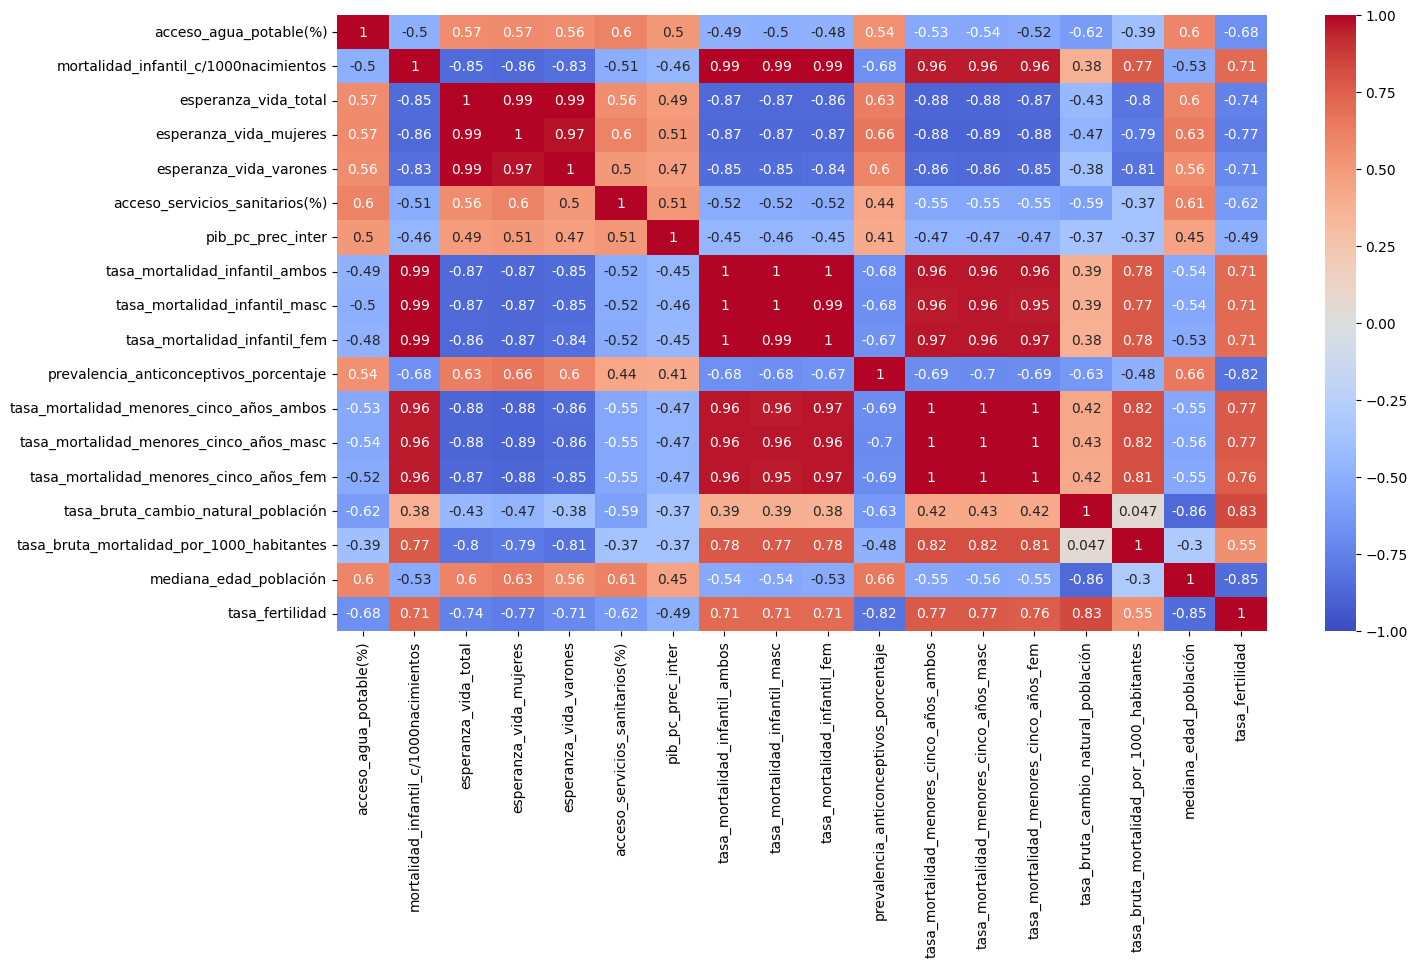

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (15,8))
sns.heatmap(corr_matrix, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

Descubrimos que a pesar de tener la información segmentada en ciertos indicadores para hombres y mujeres, no existe ningun indicador seleccionado que tenga impacto más significativo en la esperanza de vida al nacer de las mujeres que la de los hombres. Por lo tanto sería bueno deshacernos de esa información.

In [ ]:
ingreso_bajo.drop(columns=['tasa_mortalidad_infantil_masc',
                            'tasa_mortalidad_infantil_fem',
                            'tasa_mortalidad_menores_cinco_años_masc',
                            'tasa_mortalidad_menores_cinco_años_fem',
                    ],
                        inplace=True)

# Graficas de Esperanza de vida

In [50]:
import plotly.express as px

fig = px.line(tabla, 
                x=pd.to_datetime(tabla.index.get_level_values('date')), 
                y="esperanza_vida_total", 
                title='Esperanza de vida en todos los países',
                color= tabla.index.get_level_values('countryiso3code'))
fig.show()

In [51]:
ingreso_bajo.reset_index(inplace=True)
ingreso_medio_bajo.reset_index(inplace=True)
ingreso_medio_alto.reset_index(inplace=True)
ingreso_alto.reset_index(inplace=True)

In [37]:
prom_ingreso_bajo = ingreso_bajo.groupby('date').mean()
prom_ingreso_medio_bajo = ingreso_medio_bajo.groupby('date').mean()
prom_ingreso_medio_alto = ingreso_medio_alto.groupby('date').mean()
prom_ingreso_alto = ingreso_alto.groupby('date').mean()

In [33]:
promedio = df_twb.groupby(['nivel_ingreso','date']).mean()

In [34]:
promedio.reset_index(inplace=True)

In [35]:
import plotly.express as px

fig = px.line(promedio, 
                x='date', 
                y="esperanza_vida_total", 
                title='Esperanza de vida agrupado por nivel de ingreso',
                color= 'nivel_ingreso')
fig.show()

In [40]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=prom_ingreso_bajo.index, 
                y=prom_ingreso_bajo.esperanza_vida_total,
                name="Promedio de esperanza de vida, bajos ingreso"
))
fig.add_trace(go.Scatter(x=prom_ingreso_medio_bajo.index, 
                y=prom_ingreso_medio_bajo.esperanza_vida_total,
                name="Promedio de esperanza de vida, medio bajo ingreso"
))


fig.show()

In [50]:
ingreso_bajo.index.get_level_values('countryiso3code').unique()

Index(['AFG', 'ALB', 'AGO', 'ARM', 'AZE', 'BGD', 'BEN', 'BTN', 'BOL', 'BIH',
       'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAF', 'TCD', 'CHN', 'COM', 'COD',
       'COG', 'CIV', 'DOM', 'EGY', 'SLV', 'GNQ', 'ERI', 'ETH', 'GMB', 'GEO',
       'GHA', 'GTM', 'GIN', 'GNB', 'GUY', 'HTI', 'HND', 'IND', 'IDN', 'IRQ',
       'KEN', 'KIR', 'KGZ', 'LAO', 'LSO', 'LBR', 'MDG', 'MWI', 'MLI', 'MRT',
       'MDA', 'MNG', 'MOZ', 'MMR', 'NPL', 'NIC', 'NER', 'NGA', 'PAK', 'PNG',
       'PER', 'PHL', 'RWA', 'WSM', 'STP', 'SEN', 'SLE', 'SLB', 'SOM', 'SSD',
       'LKA', 'SDN', 'SUR', 'SYR', 'TJK', 'TZA', 'TLS', 'TGO', 'TKM', 'UGA',
       'UKR', 'UZB', 'VNM', 'YEM', 'ZMB', 'ZWE'],
      dtype='object', name='countryiso3code')

In [55]:
idx=pd.IndexSlice
analisis = tabla.loc[idx['SLV', :, :],'nivel_ingreso']
analisis

countryiso3code  date
SLV              2020    lower_middle_income
                 2019    lower_middle_income
                 2018    lower_middle_income
                 2017    lower_middle_income
                 2016    lower_middle_income
                 2015    lower_middle_income
                 2014    lower_middle_income
                 2013    lower_middle_income
                 2012    lower_middle_income
                 2011    lower_middle_income
                 2010    lower_middle_income
                 2009    lower_middle_income
                 2008    lower_middle_income
                 2007    lower_middle_income
                 2006    lower_middle_income
                 2005    lower_middle_income
                 2004    lower_middle_income
                 2003    lower_middle_income
                 2002    lower_middle_income
                 2001    lower_middle_income
                 2000    lower_middle_income
                 1999    lower_mi

In [53]:
ingreso_bajo.columns

Index(['acceso_agua_potable(%)', 'mortalidad_infantil_c/1000nacimientos',
       'esperanza_vida_total', 'esperanza_vida_mujeres',
       'esperanza_vida_varones', 'acceso_servicios_sanitarios(%)',
       'pib_pc_prec_inter', 'nivel_ingreso', 'tasa_mortalidad_infantil_ambos',
       'prevalencia_anticonceptivos_porcentaje',
       'tasa_mortalidad_menores_cinco_años_ambos',
       'tasa_bruta_cambio_natural_población',
       'tasa_bruta_mortalidad_por_1000_habitantes', 'mediana_edad_población',
       'tasa_fertilidad'],
      dtype='object')